# Neural Networks for Data Science Applications
## Second Homework: Experimenting with continual learning

**Name**: Michelangelo Saveriano

**Matricola**: 1823326

> ✍ Upload the completed notebook **at least two days prior** to the exam's date on Google Classroom. For example, for the January call (19/01/2022), the final deadline is **17/01/2022 at 23:59**.

**Overview**: The homework is composed of four parts: (i) selecting a dataset; (ii) implementing a custom component (ONLY if you did not submit the first homework or if you want to improve your mark); (iii) implementing a neural network and training it on the dataset; (iv) implementing an additional continual learning strategy on top of it.

> 🟨 **Important - before starting**: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*.

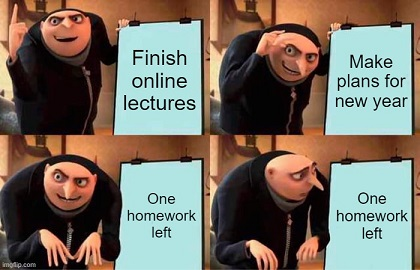

In [ ]:
! pip install spektral -qqq

import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, metrics, regularizers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
import spektral
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
import itertools
from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive')

tf.random.set_seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Warm-up: Selecting a dataset

During the course, we were able to see only a small selection of datasets. For this homework, you are free to select any dataset that you believe interesting (images, audios, texts, graphs)...

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. As a rule of thumb, the choice of dataset will not influence the mark (with few exceptions, see below), so you can select a complexity that you believe adequate to your skills.

🟩 **Please do:**

1. Provide a complete description of the dataset and the task below.
2. You are not limited to classification tasks. However, tasks that were not seen during the course (e.g., segmentation) **must be thoroughly explained in the text**.

🟥 **Please don't:**

1. Absolutely do not use datasets that were seen during our lab sessions.
2. Try not to use MNIST, CIFAR-10, CIFAR-100, or any simple variation (e.g., Fashion MNIST).

**DESCRIPTION OF THE CODE**: *Provide a small description of the dataset here (e.g., source, task, bibliographic reference if necessary...).*

The raw data we used is a traffic trace, it can be found [here](http://mawi.wide.ad.jp/mawi/samplepoint-F/2022/202208011400.html), consisting of $\sim 100M$ packets captured from Mon Aug 1 14:00:00 2022 to Mon Aug 1 14:15:00 2022. In order to be able to feed the data into a *Neural Network* we have followed the following steps:
* sampled the data at freqency $f=2Hz$, computing for each source-destination pair the average connection speed in *bps* for that time interval;
* we reduced the number of edges in the graph to $E=500$, keeping the top-500 source-destination pairs for higher amount of data transfered .

The cleaned data are converted into a $(T, N, 2)$ tensor, where:

* $T=1800$ is the number of timesteps 
* $N=594$ is the number of nodes in the graph

and for each node, for each timestep we compute $2$ features: *transmission* (**OutTraffic**) and *receiving* (**InTraffic**) rate.

Each node, at each moment in time, is classified into 6 classes depending on the average transfer rate it will experience in the next $fw$ timesteps (we choose a window size of $10s ⇒ fw = 20$). Given an average forward transfer rate (*bps*) $r$ the classification is the following:

0. $0 \leq r \leq 2^5 = 32bps$
1. $2^{5}  < r \leq 2^{10} \sim 1 kbps$
2. $2^{10} < r \leq 2^{15} \sim 32 kbps$
3. $2^{15} < r \leq 2^{20} \sim 1 Mbps$
4. $2^{20} < r \leq 2^{25} \sim 33 Mbps$
5. $2^{25} < r $

Since a node can experience two types of traffic, i.e. *InTraffic* and *OutTraffic*, the final class $c$ is computed as the maximum between the two classes $c = \max(\text{InTrafficClass}, \text{OutTrafficClass})$.

In [ ]:
# Insert any data loading code here. If the data loading part is complex,
# consider using a separate .py file that you can attach to the submission.

def classify_traffic(traffic_matrix):
    return np.floor(np.clip(np.log2(traffic_matrix.mean(axis=0) + 1) / 5, 0, 5)).max(axis=-1, keepdims=False).astype(np.int32)

def create_timeseries_tensor_from_array(data, target, sequence_length):
  dataset = tf.keras.utils.timeseries_dataset_from_array(data, target, sequence_length=sequence_length)
  D = np.swapaxes(np.vstack([_d for _d, _ in dataset.as_numpy_iterator()]), 1, 2)
  T = np.vstack([_t for _, _t in dataset.as_numpy_iterator()])
  return D, T

def create_dataset(traffic_data_filename, sequence_length, forward_window = 20, 
                   test_size=.2, val_size=.15):
    traffic_data = pd.read_csv(traffic_data_filename)

    # Identify parameters
    N = pd.concat([traffic_data['src'], traffic_data['dst']]).nunique()
    E = len(traffic_data[['src', 'dst']].drop_duplicates())
    T = traffic_data['timeId'].max() + 1
    F = 2

    # Create bps matrix
    bps_data_matrix = np.zeros((T, N, F))
    for srcId, dstId, timeId, bps in traffic_data[['src', 'dst', 'timeId', 'bps']].values:
        bps_data_matrix[timeId, srcId, 0] += bps
        bps_data_matrix[timeId, dstId, 1] += bps
    
    # Create target traffic classification matrix
    target_traffic_classification = np.zeros((T, N))
    for i in range(T-forward_window):
        target_traffic_classification[i] = classify_traffic(bps_data_matrix[i:i + forward_window])

    # Compute the adjacency matrix 
    A = np.zeros((N, N))
    for src, dst in traffic_data[['src', 'dst']].drop_duplicates().values:
        A[src, dst] = 1
        A[dst, src] = 1
        
    # Define data and target
    data = np.log10(bps_data_matrix[:-1] + 1).astype(np.float32)
    target = target_traffic_classification[1:].astype(np.int32)
    
    # Split in train, test and validation
    test_size = 1 - val_size - test_size

    train_data = data[:int(T * test_size)]
    val_data   = data[int(T * test_size):int(T * (test_size + val_size))]
    test_data  = data[int(T * (test_size + val_size)):]
    train_target = target[:int(T * test_size)]
    val_target   = target[int(T * test_size):int(T * (test_size + val_size))]
    test_target  = target[int(T * (test_size + val_size)):]

    # Return the dataset
    return (create_timeseries_tensor_from_array(train_data, train_target, sequence_length=sequence_length),
            create_timeseries_tensor_from_array(val_data, val_target, sequence_length=sequence_length),
            create_timeseries_tensor_from_array(test_data, test_target, sequence_length=sequence_length),
            A, N, F)

w = 50
n_labels = 6
(train_data, train_target), (val_data, val_target), (test_data, test_target), A, N, F = create_dataset("/content/drive/MyDrive/NNDS/data/temporal_traffic_data.csv", sequence_length=w)
L = spektral.utils.gcn_filter(A, symmetric=True)
# X, y = ...

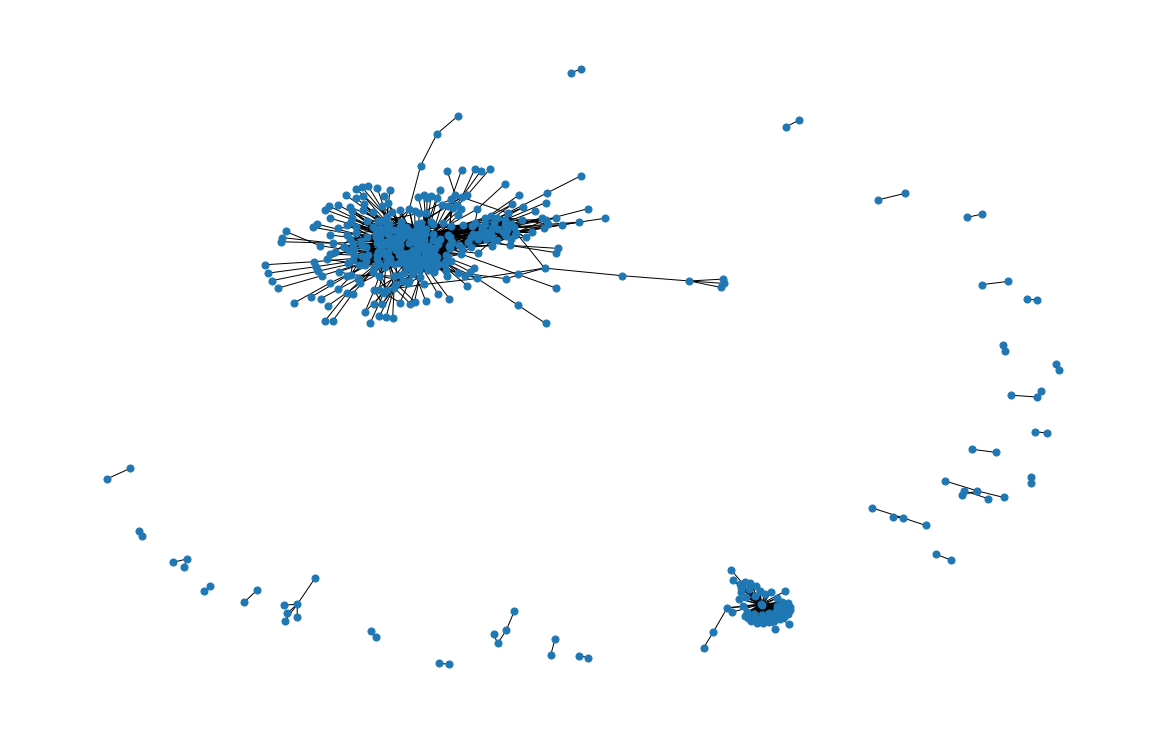

In [ ]:
plt.figure(figsize=(16, 10))
G = nx.from_numpy_matrix(A)
pos = nx.spring_layout(G, k=5/10, iterations=500)
nx.draw(G, pos, node_size=50)

### Exercise 1: Implementing a custom object (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 3/5). For a mark of 4/5, an additional point can also be recovered during the exam.**

**To recap**: if you submitted the mid-term homework, implement only Exercises 2 and 3, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1, 2, and 3 for a total of *15 points*. 

The **S-Shaped ReLU** (SReLU) [1] is defined as:

$$
\phi(s) = \begin{cases} t^r + a^r(s - t^r) & \text{ if } s > t^r \\ s & \text{ if } t^r > s > t^l \\ t^l + a^l(s - t^l) & \text{ if } s < t^l \end{cases} \,.
$$

The four parameters $t^r, a^r, t^l, a^l$ are trained via back-propagation, and they are **different for each unit in the layer**. For this exercise, you need to define a `tf.keras.Layer` implementing the SReLU logic. Then, plot an example of the resulting activation function, and its derivative (computed using the GradientTape). 

> 🧐 Keep in mind that you are replicating Exercises 1 and 2 from the first homework, so any consideration from there apply also here.

[1] https://arxiv.org/pdf/1512.07030v1.pdf

In [ ]:
# Insert your component here
# class SReLU(tf.keras.Layer):
#   pass
# ...

In [ ]:
# Show a plot of the SReLU and its derivative

### Exercise 2: Train on your data (4 points)

This part is straightforward: create a model, according to everything we saw in the course, and train it on the data you have loaded. If you did Exercise 1, **include your custom component here**. Otherwise, you are free to use any components that were not included in the course (layers, losses, metrics, ...), provided you give a brief description below.

**DESCRIPTION OF THE CODE**: *Provide a small description of (i) the model, (ii) the task, (iii) any notable features of your training process.*

1. **The Model**

The model takes in input, for each node, a time series containing the last $50$ InTraffic and OutTraffic (rate) and predicts the traffic class, among the $6$ defined above, for each node in the graph. The model is composed of 2 parts: a time series embedder and a graph attention network.

The time series embedding is performed using *Conv1D*, *MaxPool1D*, *BatchNormalization* to stabilize the learning process and a *GlobalAveragePooling1D* to extract the final embeddings. 

The embeddings are then feed into $2$ Graph Attention Convolution layers in which we compute the final predictions.

2. **The task**

As said before the task is forecasting the traffic class of each node, which depends on the average transfer rate the node will experience in the next $20s$

3. **The Training**

In this stage the training is done through the standard *fit* function.

In [ ]:
def build_gat(x_in, l_in, n_labels, emb_feat=64, mean=0, variance=1, reg=5e-5):
  norm = tf.keras.layers.Normalization(mean=mean, variance=variance)(x_in)

  c1 = layers.Conv1D(emb_feat, 5, activation='linear', dilation_rate=2, 
                     kernel_regularizer=regularizers.L1L2(l1=reg, l2=reg))(norm)
  b1 = layers.BatchNormalization()(c1)
  a1 = layers.ReLU()(b1)
  p1 = layers.MaxPool1D()(a1)

  c2 = layers.Conv1D(emb_feat, 5, activation='linear', dilation_rate=2, 
                     kernel_regularizer=regularizers.L1L2(l1=reg, l2=reg))(p1)
  b2 = layers.BatchNormalization()(c2)
  a2 = layers.ReLU()(b2)
  p2 = layers.MaxPool1D()(a2)

  c3 = layers.Conv1D(emb_feat, 3, activation='linear', dilation_rate=2, 
                     kernel_regularizer=regularizers.L1L2(l1=reg, l2=reg))(p2)
  b3 = layers.BatchNormalization()(c3)
  a3 = layers.ReLU()(b3)
  
  avg = layers.GlobalAveragePooling1D()(a3)

  gc1 = spektral.layers.GATConv(emb_feat, attn_heads=4, concat_heads=True,
                                activation="relu",  kernel_regularizer=regularizers.L1L2(l1=reg, l2=reg))([avg, l_in])
  gc2 = spektral.layers.GATConv(n_labels, attn_heads=1, concat_heads=False,
                                activation="softmax",  kernel_regularizer=regularizers.L1L2(l1=reg, l2=reg))([gc1, l_in])
               
  return Model(inputs=[x_in, l_in], outputs=gc2)

In [ ]:
# Keras Sequence used in the fit
class GraphSequence(tf.keras.utils.Sequence):
    def __init__(self, data, target, L, shuffle=True):
      self._data = data
      self._target = target
      self._L = L
      self.index = np.arange(self._data.shape[0])
      self.shuffle = True
      if self.shuffle:
        self.index = np.random.choice(self._data.shape[0], size=self._data.shape[0], replace=False)

    def __len__(self):
      if self.shuffle:
        self.index = np.random.choice(self._data.shape[0], size=self._data.shape[0], replace=False)
      return self._data.shape[0]

    def __getitem__(self, idx):
      return [self._data[self.index[idx]], L], self._target[self.index[idx]]

In [ ]:
# Instanciate the Model
x_in = layers.Input(shape=(w, F,))
l_in = layers.Input((N,))

model = build_gat(x_in, l_in, n_labels, 
                  mean=train_data.mean(), variance=train_data.var())

# Instanciate the Loss Function and the Optimizer
loss_fn = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=loss_fn, 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Print the Model Architecture 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 2)]      0           []                               
                                                                                                  
 normalization (Normalization)  (None, 50, 2)        0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 42, 64)       704         ['normalization[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 42, 64)      256         ['conv1d[0][0]']                 
 alization)                                                                                   

In [ ]:
# You can train using fit() or a custom training loop, equivalently.
early_stop_call = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=7)

model.fit(
    x=GraphSequence(train_data, train_target, L),
    epochs=20,
    validation_data=GraphSequence(val_data, val_target, L),
    callbacks = [early_stop_call]
)

Epoch 1/20
1120/1120 [==============================] - 33s 13ms/step - loss: 0.9500 - sparse_categorical_accuracy: 0.6575 - val_loss: 0.5923 - val_sparse_categorical_accuracy: 0.8168
Epoch 2/20
1120/1120 [==============================] - 14s 12ms/step - loss: 0.8258 - sparse_categorical_accuracy: 0.6927 - val_loss: 0.5276 - val_sparse_categorical_accuracy: 0.8349
Epoch 3/20
1120/1120 [==============================] - 14s 12ms/step - loss: 0.7970 - sparse_categorical_accuracy: 0.7013 - val_loss: 0.4855 - val_sparse_categorical_accuracy: 0.8408
Epoch 4/20
1120/1120 [==============================] - 14s 12ms/step - loss: 0.7834 - sparse_categorical_accuracy: 0.7049 - val_loss: 0.4967 - val_sparse_categorical_accuracy: 0.8551
Epoch 5/20
1120/1120 [==============================] - 15s 13ms/step - loss: 0.7658 - sparse_categorical_accuracy: 0.7103 - val_loss: 0.4620 - val_sparse_categorical_accuracy: 0.8535
Epoch 6/20
1120/1120 [==============================] - 14s 13ms/step - loss: 0.

In [ ]:
model.evaluate(GraphSequence(test_data, test_target, L), return_dict=True)

311/311 [==============================] - 2s 5ms/step - loss: 0.3704 - sparse_categorical_accuracy: 0.8892


{'loss': 0.37042996287345886,
 'sparse_categorical_accuracy': 0.8892136812210083}

### Exercise 3 (6 points): Continual learning

In the third part of the homework, you are asked to implement a continual learning setup with the following characteristics: 

* **Task-incremental learning**: split the dataset in > 2 task (e.g., dividing the outputs into disjoint subsets). The model will be a multi-head model, similar to what we saw in the slides.
* Train the model on the tasks sequentially, using **elastic weight consolidation** (EWC).
* Show at least the mean accuracy (as defined in the slides) and the backward transfer after training. You can also show some *performance graphs* similar to the ones from the slides (with the id of the task on the x-axis).

🟩 **Please do:**

1. Carefully read [this guide](https://www.tensorflow.org/guide/keras/train_and_evaluate) from the TensorFlow website. You can implement EWC in several ways.
2. It would be preferable to implement the accuracy and the backward transfer by subclassing `tf.keras.metrics.Metric`.
3. Comment the code and provide a complete description below.

🟥 **Please don't:**

1. Copy-paste from the web (immediate zero mark).

In this section I splitted the original task into 3 as follows:

- Task $0 → \text{Labels} = \{0, 1\}$
- Task $1 → \text{Labels} = \{2, 3\}$
- Task $2 → \text{Labels} = \{4, 5\}$

Since each graph contains nodes whose predictions belong to different tasks I have used masks evaluating the loss of only those nodes whose prediction belongs to the task we are training the newtwork for at the moment.

The network architecture is kept the same with the only difference of the output layer since in this case we have 3 separated outputs.

The training is done in the *train* function which takes in input, among the others, the entire dataset (in the form of a `keras.utils.Sequence` defined above), the task id to perform the dataset subsetting and the ewc lambda to evaluate the penalty term. If the ewc lambda is set to $0$ no penalty will be applied.

**Please notice** that in order to compute the penalty in the correct way the tasks must be learnt in order, ie $0 → 1 → 2$, otherwise the Fisher matrix computed will be wrong.

For the EWC penalty I have taken some inspiration from [this](https://github.com/db434/EWC) repository.

In [ ]:
# Define metrics here:
class BackwardTransfer(tf.keras.metrics.Metric):
  def __init__(self, name="backward_transfer", **kwargs):
    super(BackwardTransfer, self).__init__(name=name, **kwargs)
    self.sum_backward_transfer = self.add_weight(name="sum_backward_transfer", initializer="zeros")
    self.n_task = 0
    self.R = []

  def update_state(self, accuracies_list):
    if len(accuracies_list) != self.n_task + 1:
      raise Exception(f'Exception: expected {self.n_task + 1} accuracies, got {len(accuracies_list)}')
    self.n_task += 1
    self.R.append(accuracies_list)

  def result(self):
    self.sum_backward_transfer.assign(0.0)
    for i in range(1, self.n_task):
      for j in range(i):
        self.sum_backward_transfer.assign_add(self.R[i][j] - self.R[j][j])
    return self.sum_backward_transfer / (self.n_task * (self.n_task - 1) / 2)

  def reset_state(self):
    self.sum_backward_transfer.assign(0.0)
    self.n_task = 0
    self.R = []

class GlobalAccuracy(tf.keras.metrics.Metric):
  def __init__(self, name="global_accuracy", **kwargs):
    super(GlobalAccuracy, self).__init__(name=name, **kwargs)
    self.sum_global_accuracy = self.add_weight(name="sum_global_accuracy", initializer="zeros")
    self.n_task = 0

  def update_state(self, accuracies_list):
    if len(accuracies_list) != self.n_task + 1:
      raise Exception(f'Exception: expected {self.n_task + 1} accuracies, got {len(accuracies_list)}')
    self.n_task += 1
    self.sum_global_accuracy.assign_add(tf.math.reduce_sum(accuracies_list[:-1]))

  def result(self):
    return self.sum_global_accuracy / (self.n_task * (self.n_task - 1) / 2)

  def reset_state(self):
    self.sum_global_accuracy.assign(0.0)
    self.n_task = 0

In [ ]:
# Split the dataset
n_tasks = 3
n_labels_per_task = 2

def create_mask(y, task_labels):
  mask = np.zeros((y.shape[0],)).astype(bool)
  for label in task_labels:
    mask |= (y == label).flatten()
  return mask

task_id_labels_map = [
    [i + j for j in range(n_labels_per_task)] for i in range(0, n_tasks*n_labels_per_task, n_labels_per_task)
  ]

In [ ]:
# Define the multi-head model
# Tip: the functional API is pretty good here

def build_multi_head_model(x_in, l_in, n_tasks, n_labels_per_task, emb_feat=64, mean=0, variance=1, reg=5e-5):
  norm = tf.keras.layers.Normalization(mean=mean, variance=variance)(x_in)

  c1 = layers.Conv1D(emb_feat, 5, activation='linear', dilation_rate=2, 
                     kernel_regularizer=regularizers.L1L2(l1=reg, l2=reg))(norm)
  b1 = layers.BatchNormalization()(c1)
  a1 = layers.ReLU()(b1)
  p1 = layers.MaxPool1D()(a1)

  c2 = layers.Conv1D(emb_feat, 5, activation='linear', dilation_rate=2, 
                     kernel_regularizer=regularizers.L1L2(l1=reg, l2=reg))(p1)
  b2 = layers.BatchNormalization()(c2)
  a2 = layers.ReLU()(b2)
  p2 = layers.MaxPool1D()(a2)

  c3 = layers.Conv1D(emb_feat, 3, activation='linear', dilation_rate=2, 
                     kernel_regularizer=regularizers.L1L2(l1=reg, l2=reg))(p2)
  b3 = layers.BatchNormalization()(c3)
  a3 = layers.ReLU()(b3)
  
  avg = layers.GlobalAveragePooling1D()(a3)

  gc1 = spektral.layers.GATConv(emb_feat, attn_heads=4,
               concat_heads=True,
               activation="relu")([avg, l_in])
  
  out = [
      spektral.layers.GATConv(n_labels_per_task, attn_heads=1,
               concat_heads=False,
               activation="softmax")([gc1, l_in]) for _ in range(n_tasks)
  ]
               
  return Model(inputs=[x_in, l_in], outputs=out)

# Instanciate the Model
x_in = layers.Input(shape=(w, F,))
l_in = layers.Input((N,))

model_multi = build_multi_head_model(x_in, l_in, n_tasks, n_labels_per_task,
                               mean=train_data.mean(), variance=train_data.var())

# Instanciate the Loss Function and the Optimizer
loss_fn = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=1e-3)
model_multi.compile(optimizer=optimizer, loss=[loss_fn]*3, 
                    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Print the Model Architecture 
model_multi.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 2)]      0           []                               
                                                                                                  
 normalization_1 (Normalization  (None, 50, 2)       0           ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 42, 64)       704         ['normalization_1[0][0]']        
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 42, 64)      256         ['conv1d_3[0][0]']         

In [ ]:
def compute_fisher(model, train_data, task_id, n_batches=50):
  weights = model.trainable_weights
  variance = [tf.zeros_like(tensor) for tensor in weights]
  
  if n_batches == -1:
    n_batches = len(train_data)

  for i in np.random.choice(len(train_data), replace=False, size=n_batches):
    # Load samples and mask
    x, y = train_data[i]
    mask = create_mask(y, task_id_labels_map[task_id])

    # Evaluate gradients of the log likelihood
    with tf.GradientTape() as tape:
      pred = model(x)[task_id]
      log_likelihood = tf.math.log(pred)
    gradients = tape.gradient(log_likelihood, weights)

    # Update the variance
    for idx, grad in enumerate(gradients):
      if grad is not None:
        variance[idx] += (grad ** 2)

  # Normalize the variance dividing by the number of samples
  fisher = [var / n_batches for var in variance]
  return fisher

def ewc_penalty(model, fisher, old_weights):
  penalty = 0
  for F_i, theta_i, theta_old_i in zip(fisher, model.trainable_variables, old_weights):
    penalty += tf.math.reduce_sum(F_i * tf.math.square(theta_i - theta_old_i))
  return penalty

def evaluate_model(model, data, task_id, task_id_labels_map, n_batches=50):
  metric = metrics.SparseCategoricalAccuracy()

  if (n_batches == -1)  or (n_batches > len(data)):
    n_batches = len(data)

  for i in np.random.choice(len(data), replace=False, size=n_batches):
    # Load samples and mask
    x, y = data[i]
    mask = create_mask(y, task_id_labels_map[task_id])
    # Compute predictions
    pred = model(x)[task_id]
    # Update the metric
    metric.update_state(y[mask] - 2*task_id, pred[mask])

  return metric.result().numpy()

def evaluate_performance(model, data, task_id, task_id_labels_map, n_batches=150, print_perfomance=True):
  # Evaluate the accuracy of the model for all the tasks whose id <= task_id
  accuracies = [evaluate_model(model, data, task, task_id_labels_map, n_batches=n_batches) for task in range(task_id + 1)]
  # Print the accuracies if requested
  if print_perfomance:
    print(f'Model trained on task: {task_id}')
    print('Accuracies:')
    for task in range(task_id + 1):
      print(f'  - Task: {task}, Accuracy: {accuracies[task]}')
  return accuracies
  
def train(model, train_data, epochs, optimizer, loss_fn, task_id, lambda_ewc, val_data, n_labels_per_task=2, print_tqdm=False):
  task_id_labels_map = [
    [i + j for j in range(n_labels_per_task)] for i in range(0, (task_id+1)*n_labels_per_task, n_labels_per_task)
  ]
  accuracies_list_train = []
  accuracies_list_val = []
  # Save weights before the training 
  old_weights = [weight.numpy() for weight in model.trainable_variables]

  if lambda_ewc > 0:
    # Compute the fisher matrix diagonal for each of the task trained before
    fishers = [compute_fisher(model, train_data, i) for i in range(task_id)]

  for epoch in range(1, epochs+1):
    # Iterate over the graphs
    iter = range(len(train_data))
    if print_tqdm:
      iter = tqdm(range(len(train_data)))

    for i in iter:
      # Load samples and training mask
      x, y = train_data[i]
      mask = create_mask(y, task_id_labels_map[task_id])

      # Compute gradients
      with tf.GradientTape() as tape:
        pred = model(x, training=True)[task_id]
        loss = loss_fn(y[mask] % n_labels_per_task, pred[mask])
        # Add ewc penalty if lamda > 0
        if lambda_ewc > 0:
          # Add a penalty for each task trained before
          for fisher in fishers:
            loss += lambda_ewc * ewc_penalty(model, fisher, old_weights) / 2

      # Update weights
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(((grad, var) for (grad, var) in zip(gradients, model.trainable_variables) if grad is not None))

    # Print the validation accuracy every 5 epochs
    if not epoch % 5:
      print(f'Epoch {epoch}', end=' ')
    accuracies_list_train.append(evaluate_performance(model, train_data, task_id, task_id_labels_map, n_batches=50, print_perfomance=False))
    accuracies_list_val.append(evaluate_performance(model, val_data, task_id, task_id_labels_map, n_batches=150, print_perfomance=not epoch % 5))
  return accuracies_list_train, accuracies_list_val

In [ ]:
# Initialize the metrics
train_backward_transfer = BackwardTransfer()
train_global_accuracy = GlobalAccuracy()
val_backward_transfer = BackwardTransfer()
val_global_accuracy = GlobalAccuracy()

# Train on the first task
n_epochs = 10
accuracies_list_train, accuracies_list_val = train(model_multi, GraphSequence(train_data, train_target, L), n_epochs, optimizer, loss_fn, task_id=0, 
                                                   lambda_ewc=0, val_data=GraphSequence(val_data, val_target, L), print_tqdm=True)

# Update backward transfer and global accuracy
# Train
train_accuracies = evaluate_performance(model_multi, GraphSequence(train_data, train_target, L), 0, task_id_labels_map, n_batches=-1, print_perfomance=False)
train_backward_transfer.update_state(train_accuracies)
train_global_accuracy.update_state(train_accuracies)
# Validation
val_accuracies = evaluate_performance(model_multi, GraphSequence(val_data, val_target, L), 0, task_id_labels_map, n_batches=-1, print_perfomance=False)
val_backward_transfer.update_state(val_accuracies)
val_global_accuracy.update_state(val_accuracies)

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

Epoch 5 Model trained on task: 0
Accuracies:
  - Task: 0, Accuracy: 0.9803573489189148


  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

Epoch 10 Model trained on task: 0
Accuracies:
  - Task: 0, Accuracy: 0.9828219413757324


In [ ]:
# Train on the following tasks
lambda_ewc = 0.03

# Train on the second task
accuracies_list_train_aux, accuracies_list_val_aux = train(model_multi, GraphSequence(train_data, train_target, L), epochs=n_epochs, 
                                                   optimizer=optimizer, loss_fn=loss_fn, task_id=1, 
                                                   lambda_ewc=lambda_ewc, val_data=GraphSequence(val_data, val_target, L), print_tqdm=True)
accuracies_list_train += accuracies_list_train_aux
accuracies_list_val += accuracies_list_val_aux

# Update and print backward transfer and global accuracy
train_accuracies = evaluate_performance(model_multi, GraphSequence(train_data, train_target, L), task_id=1, task_id_labels_map=task_id_labels_map, n_batches=-1, print_perfomance=False)
train_backward_transfer.update_state(train_accuracies)
train_global_accuracy.update_state(train_accuracies)
print(f'Train Backward Transfer: {train_backward_transfer.result()}, Train Global Accuracy: {train_global_accuracy.result()}')

val_accuracies = evaluate_performance(model_multi, GraphSequence(val_data, val_target, L), task_id=1, task_id_labels_map=task_id_labels_map, n_batches=-1, print_perfomance=False)
val_backward_transfer.update_state(val_accuracies)
val_global_accuracy.update_state(val_accuracies)
print(f'Validation Backward Transfer: {val_backward_transfer.result()}, Validation Global Accuracy: {val_global_accuracy.result()}')

# Train on the third task
accuracies_list_train_aux, accuracies_list_val_aux = train(model_multi, GraphSequence(train_data, train_target, L), epochs=n_epochs, 
                                                   optimizer=optimizer, loss_fn=loss_fn, task_id=2, 
                                                   lambda_ewc=lambda_ewc, val_data=GraphSequence(val_data, val_target, L), print_tqdm=True)
accuracies_list_train += accuracies_list_train_aux
accuracies_list_val += accuracies_list_val_aux

# Update and print backward transfer and global accuracy
train_accuracies = evaluate_performance(model_multi, GraphSequence(train_data, train_target, L), task_id=2, task_id_labels_map=task_id_labels_map, n_batches=-1, print_perfomance=False)
train_backward_transfer.update_state(train_accuracies)
train_global_accuracy.update_state(train_accuracies)
print(f'Train Backward Transfer: {train_backward_transfer.result()}, Train Global Accuracy: {train_global_accuracy.result()}')

val_accuracies = evaluate_performance(model_multi, GraphSequence(val_data, val_target, L), task_id=2, task_id_labels_map=task_id_labels_map, n_batches=-1, print_perfomance=False)
val_backward_transfer.update_state(val_accuracies)
val_global_accuracy.update_state(val_accuracies)
print(f'Validation Backward Transfer: {val_backward_transfer.result()}, Validation Global Accuracy: {val_global_accuracy.result()}')

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

Epoch 5 Model trained on task: 1
Accuracies:
  - Task: 0, Accuracy: 0.981862485408783
  - Task: 1, Accuracy: 0.8944461941719055


  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

Epoch 10 Model trained on task: 1
Accuracies:
  - Task: 0, Accuracy: 0.9815629720687866
  - Task: 1, Accuracy: 0.8953409194946289
Train Backward Transfer: -0.0004610419273376465, Train Global Accuracy: 0.9837508201599121
Validation Backward Transfer: -0.0005858540534973145, Validation Global Accuracy: 0.9818204641342163


  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

Epoch 5 Model trained on task: 2
Accuracies:
  - Task: 0, Accuracy: 0.9819400310516357
  - Task: 1, Accuracy: 0.8923327922821045
  - Task: 2, Accuracy: 0.9639362692832947


  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

Epoch 10 Model trained on task: 2
Accuracies:
  - Task: 0, Accuracy: 0.9822576642036438
  - Task: 1, Accuracy: 0.8938281536102295
  - Task: 2, Accuracy: 0.9635829329490662
Train Backward Transfer: -0.00029573836945928633, Train Global Accuracy: 0.9589677453041077
Validation Backward Transfer: -0.00029653310775756836, Validation Global Accuracy: 0.9529380798339844


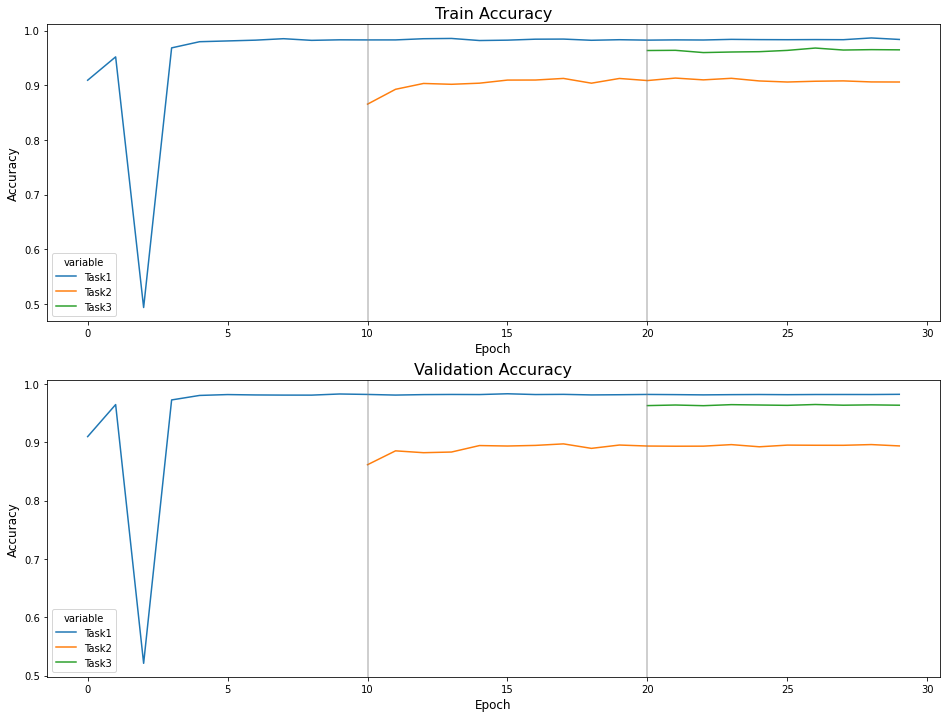

In [ ]:
# Plot the results here (anything is okay)
fig, [ax1, ax2] = plt.subplots(2, figsize=(16, 12))
result_df_train = pd.DataFrame(list(map(lambda x: x + [None] * (n_tasks - len(x)), accuracies_list_train)), columns=['Task' + str(i) for i in range(1, n_tasks+1)])
sns.lineplot(data=result_df_train.reset_index().melt('index'), 
             x='index', y='value', hue='variable', ax=ax1)
ax1.set_title('Train Accuracy', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.axvline(n_epochs, c='grey', alpha=.5)
ax1.axvline(n_epochs*2, c='grey', alpha=.5)

result_df_val = pd.DataFrame(list(map(lambda x: x + [None] * (n_tasks - len(x)), accuracies_list_val)), columns=['Task' + str(i) for i in range(1, n_tasks+1)])
sns.lineplot(data=result_df_val.reset_index().melt('index'), 
             x='index', y='value', hue='variable', ax=ax2)
ax2.set_title('Validation Accuracy', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.axvline(n_epochs, c='grey', alpha=.5)
ax2.axvline(n_epochs*2, c='grey', alpha=.5)
plt.show()

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

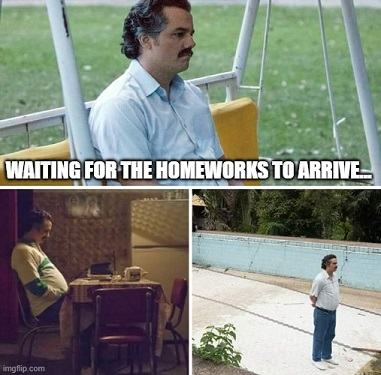